In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Generate a toy dataset
def generate_sequences(num_sequences=1000, seq_length=10, vocab_size=20):
    X = np.random.randint(1, vocab_size, size=(num_sequences, seq_length))
    y = np.copy(X)
    return X, y

vocab_size = 21  # including a padding index at 0
seq_length = 10

X_data, y_data = generate_sequences(num_sequences=1000, seq_length=seq_length, vocab_size=vocab_size)

# Convert to tensors
X_tensor = torch.LongTensor(X_data)
y_tensor = torch.LongTensor(y_data)

In [ ]:
# Cell 3: Define the SwarmAttention class
class SwarmAttention(nn.Module):
    def __init__(self, hidden_size, seq_length, num_agents=5):
        super(SwarmAttention, self).__init__()
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.num_agents = num_agents

        # Initialize agent positions (learnable parameters)
        # Positions are logits over sequence positions
        self.agent_positions = nn.Parameter(torch.randn(num_agents, seq_length))

    def forward(self, encoder_outputs, decoder_hidden, epoch, total_epochs):
        batch_size = encoder_outputs.size(0)

        # Adjust temperature dynamically
        T_initial, T_final = 5.0, 1.0
        if total_epochs > 1:
            T = T_initial - ((T_initial - T_final) * (epoch / (total_epochs - 1)))
        else:
            T = T_final  # Avoid division by zero when total_epochs is 1

        temperature = T

        # Apply temperature to softmax
        agent_distributions = F.softmax(self.agent_positions / temperature, dim=-1)

        # Add Gaussian noise
        noise_std = 0.1
        noise = torch.randn_like(agent_distributions) * noise_std
        agent_distributions = agent_distributions + noise

        # Re-normalize to ensure valid probabilities
        agent_distributions = F.softmax(agent_distributions, dim=-1)

        # Aggregate agent distributions
        attention_weights = agent_distributions.mean(dim=0)
        attention_weights = F.softmax(attention_weights, dim=-1)

        # Expand to match batch size
        attention_weights = attention_weights.unsqueeze(0).expand(batch_size, -1)  # (batch_size, seq_length)

        # Apply attention weights to encoder outputs
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (batch_size, hidden_size)

        return context, attention_weights

In [ ]:
# Cell 4: Define the Encoder class
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True)

    def forward(self, input_seq):
        # input_seq: (batch_size, seq_length)
        embedded = self.embedding(input_seq)  # (batch_size, seq_length, embedding_size)
        outputs, hidden = self.rnn(embedded)  # outputs: (batch_size, seq_length, hidden_size)
        return outputs, hidden  # hidden: (1, batch_size, hidden_size)

In [ ]:
# Cell 5: Define the Decoder class
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, seq_length, num_agents=5):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.attention = SwarmAttention(hidden_size, seq_length, num_agents=num_agents)
        self.rnn = nn.GRU(embedding_size + hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_token, decoder_hidden, encoder_outputs, epoch, total_epochs):
        # input_token: (batch_size)
        # decoder_hidden: (1, batch_size, hidden_size)
        # encoder_outputs: (batch_size, seq_length, hidden_size)

        batch_size = input_token.size(0)

        embedded = self.embedding(input_token).unsqueeze(1)  # (batch_size, 1, embedding_size)

        # Calculate context vector using swarm attention
        context, attention_weights = self.attention(
            encoder_outputs, decoder_hidden.squeeze(0), epoch, total_epochs
        )  # context: (batch_size, hidden_size)

        # Concatenate embedded input and context
        rnn_input = torch.cat([embedded, context.unsqueeze(1)], dim=2)  # (batch_size, 1, embedding_size + hidden_size)

        # Pass through RNN
        output, hidden = self.rnn(rnn_input, decoder_hidden)  # output: (batch_size, 1, hidden_size)

        # Predict next token
        output = self.out(output.squeeze(1))  # (batch_size, vocab_size)

        return output, hidden, attention_weights

In [ ]:
# Cell 6: Set hyperparameters
embedding_size = 64
hidden_size =128
num_agents = 500
batch_size = 32
num_epochs = 50
learning_rate = 0.01

In [ ]:
# Cell 7: Prepare data loaders
from torch.utils.data import DataLoader, TensorDataset

# Create dataset
dataset = TensorDataset(X_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Cell 8: Instantiate model and optimizer
encoder = Encoder(vocab_size, embedding_size, hidden_size).to(device)
decoder = Decoder(vocab_size, embedding_size, hidden_size, seq_length, num_agents=num_agents).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

In [ ]:
# Cell 9: Training loop
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0

    for batch_idx, (input_seq, target_seq) in enumerate(data_loader):
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)

        batch_size = input_seq.size(0)

        # Reset gradients
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Encoder forward pass
        encoder_outputs, encoder_hidden = encoder(input_seq)

        # Decoder initial hidden state
        decoder_hidden = encoder_hidden

        # Decoder input (start with <PAD>)
        decoder_input = torch.zeros(batch_size, dtype=torch.long, device=device)

        loss = 0

        for t in range(seq_length):
            decoder_output, decoder_hidden, attention_weights = decoder(
                decoder_input, decoder_hidden, encoder_outputs, epoch, num_epochs
            )
            # Teacher forcing
            decoder_input = target_seq[:, t]

            loss += criterion(decoder_output, target_seq[:, t])

        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1)

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

        if batch_idx % 100 == 0:
            avg_loss = total_loss / ((batch_idx + 1) * seq_length)
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], Loss: {avg_loss:.4f}')

    # Optional: Evaluate on validation set or print epoch loss
    avg_epoch_loss = total_loss / (len(data_loader) * seq_length)
    print(f'Epoch [{epoch+1}/{num_epochs}] completed with average loss: {avg_epoch_loss:.4f}')

Epoch [1/50], Batch [0], Loss: 3.0436
Epoch [1/50] completed with average loss: 2.4990
Epoch [2/50], Batch [0], Loss: 1.8745
Epoch [2/50] completed with average loss: 1.7975
Epoch [3/50], Batch [0], Loss: 1.5224
Epoch [3/50] completed with average loss: 1.4745
Epoch [4/50], Batch [0], Loss: 1.2162
Epoch [4/50] completed with average loss: 1.3423
Epoch [5/50], Batch [0], Loss: 1.1863
Epoch [5/50] completed with average loss: 1.2278
Epoch [6/50], Batch [0], Loss: 1.0828
Epoch [6/50] completed with average loss: 1.1483
Epoch [7/50], Batch [0], Loss: 1.0829
Epoch [7/50] completed with average loss: 1.0402
Epoch [8/50], Batch [0], Loss: 0.9275
Epoch [8/50] completed with average loss: 0.9730
Epoch [9/50], Batch [0], Loss: 0.8873
Epoch [9/50] completed with average loss: 0.9248
Epoch [10/50], Batch [0], Loss: 0.7497
Epoch [10/50] completed with average loss: 0.8845
Epoch [11/50], Batch [0], Loss: 0.6615
Epoch [11/50] completed with average loss: 0.8438
Epoch [12/50], Batch [0], Loss: 0.7415


In [ ]:
# Cell 10: Evaluation function
def evaluate(encoder, decoder, input_seq, epoch, num_epochs):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        input_seq = input_seq.to(device)
        batch_size = input_seq.size(0)
        encoder_outputs, encoder_hidden = encoder(input_seq)
        decoder_hidden = encoder_hidden
        decoder_input = torch.zeros(batch_size, dtype=torch.long, device=device)

        outputs = []

        for t in range(seq_length):
            decoder_output, decoder_hidden, attention_weights = decoder(
                decoder_input, decoder_hidden, encoder_outputs, epoch, num_epochs
            )
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(1).detach()
            outputs.append(decoder_input.cpu().numpy())

    outputs = np.stack(outputs, axis=1)
    return outputs

In [ ]:
# Cell 11: Test the model
# Select a random sample from the dataset
sample_idx = np.random.randint(0, len(X_tensor))
sample_input = X_tensor[sample_idx:sample_idx+1]
sample_target = y_tensor[sample_idx:sample_idx+1]

predicted_output = evaluate(encoder, decoder, sample_input, epoch=num_epochs-1, num_epochs=num_epochs)

print("Input Sequence:    ", sample_input.numpy()[0])
print("Target Sequence:   ", sample_target.numpy()[0])
print("Predicted Sequence:", predicted_output[0])


Input Sequence:     [ 7 19  5 11 18 16 14 17 14  2]
Target Sequence:    [ 7 19  5 11 18 16 14 17 14  2]
Predicted Sequence: [ 7 19 11  5 18 14 16 17  3 16]


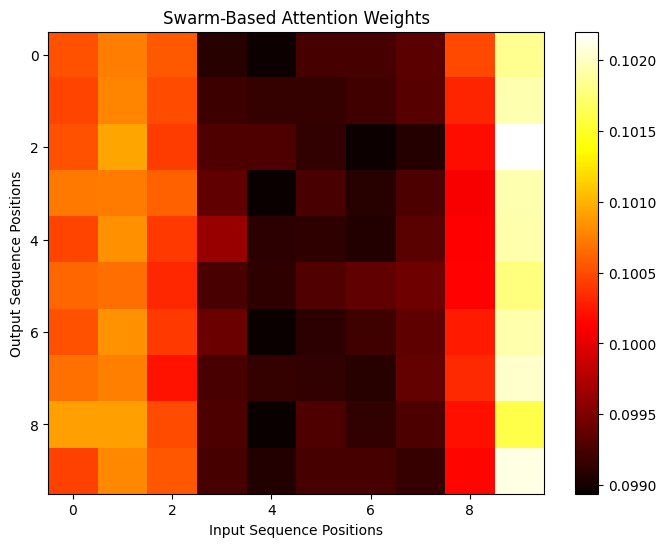

In [ ]:
# Cell 12: Evaluation with attention weights
def evaluate_with_attention(encoder, decoder, input_seq, epoch, num_epochs):
    encoder.eval()
    decoder.eval()

    attention_weights_list = []

    with torch.no_grad():
        input_seq = input_seq.to(device)
        batch_size = input_seq.size(0)
        encoder_outputs, encoder_hidden = encoder(input_seq)
        decoder_hidden = encoder_hidden
        decoder_input = torch.zeros(batch_size, dtype=torch.long, device=device)

        outputs = []

        for t in range(seq_length):
            decoder_output, decoder_hidden, attention_weights = decoder(
                decoder_input, decoder_hidden, encoder_outputs, epoch, num_epochs
            )
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(1).detach()
            outputs.append(decoder_input.cpu().numpy())
            attention_weights_list.append(attention_weights.cpu().numpy())

    outputs = np.stack(outputs, axis=1)
    attention_weights = np.stack(attention_weights_list, axis=1)  # (batch_size, seq_length, seq_length)
    return outputs, attention_weights

# Get outputs and attention weights
predicted_output, attention_weights = evaluate_with_attention(
    encoder, decoder, sample_input, epoch=num_epochs-1, num_epochs=num_epochs
)

# Plot attention weights
plt.figure(figsize=(8, 6))
plt.imshow(attention_weights[0], cmap='hot', interpolation='nearest', aspect='auto')
plt.xlabel('Input Sequence Positions')
plt.ylabel('Output Sequence Positions')
plt.title('Swarm-Based Attention Weights')
plt.colorbar()
plt.show()

**Linear Attention Decoder:**

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)

        # Linear projections for queries, keys, and values
        self.query_proj = nn.Linear(hidden_size, hidden_size)
        self.key_proj = nn.Linear(hidden_size, hidden_size)
        self.value_proj = nn.Linear(hidden_size, hidden_size)

        self.attention = LinearAttention()

    def forward(self, input_token, decoder_hidden, encoder_outputs):
        # input_token: (batch_size)
        embedded = self.embedding(input_token).unsqueeze(1)  # (batch_size, 1, embedding_size)

        # Pass through RNN
        output, hidden = self.rnn(embedded, decoder_hidden)  # output: (batch_size, 1, hidden_size)

        # Project queries, keys, and values
        queries = self.query_proj(output)  # (batch_size, 1, hidden_size)
        keys = self.key_proj(encoder_outputs)  # (batch_size, seq_length, hidden_size)
        values = self.value_proj(encoder_outputs)  # (batch_size, seq_length, hidden_size)

        # Apply activation function to ensure non-negativity
        queries = F.elu(queries) + 1  # (batch_size, 1, hidden_size)
        keys = F.elu(keys) + 1  # (batch_size, seq_length, hidden_size)

        # Compute attention output
        context = self.attention(queries, keys, values)  # (batch_size, 1, hidden_size)

        # Combine context with RNN output
        combined = output + context  # (batch_size, 1, hidden_size)

        # Predict next token
        output = self.out(combined.squeeze(1))  # (batch_size, vocab_size)

        return output, hidden